# Style Transfer

We are optimising the input image to reduce loss between output of convolutional layers(compared with output from layers when we pass the style/content image) of VGG16 model(we don't optimise weights since they are pretrained). Also we use the optimized input image as final prediction instead of output from convolutional layers.

In [1]:
import tensorflow as tf
if tf.__version__.startswith('2'):
    tf.compat.v1.disable_eager_execution()

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime

# Transfer Learning Part

In [2]:
def VGG16_AvgPool(shape):
    # we want to account for features across the entire image so get rid of the maxpool which throws away information and use average      # pooling instead.
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

    i = vgg.input
    x = i
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # replace it with average pooling
            x = AveragePooling2D()(x)
        else:
            x = layer(x)

    return Model(i, x)

In [3]:
def VGG16_AvgPool_CutOff(shape, num_convs):
    # this function creates a partial model because we don't need the full VGG network instead we need to stop at an intermediate 
    # convolution. Therefore this function allows us to specify how many convolutions we need
    # there are 13 convolutions in total we can pick any of them as the "output" of our content model

    if num_convs < 1 or num_convs > 13:
        print("num_convs must be in the range [1, 13]")
        return None

    model = VGG16_AvgPool(shape)

    n = 0
    output = None
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            n += 1
        if n >= num_convs:
            output = layer.output
            break

    return Model(model.input, output)

# Processing

In [4]:
# load the content image
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x

In [5]:
# since VGG accepts BGR this function allows us to convert our values back to RGB so we can plot it using matplotlib
# so this basically reverses the keras function - preprocess input
def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

# Style loss

Converting output to gram matrix and calculating style loss

In [6]:
def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G

In [7]:
def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

# Minimizing loss and optimising image(training)

In [8]:
# function to minimise loss by optimising input image
def minimize(fn, epochs, batch_shape, content_image):
  t0 = datetime.now()
  losses = []
  # x = np.random.randn(np.prod(batch_shape))
  x = content_image
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i+1, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]

# Modelling

In [9]:
content_path = 'images/content/elephant.jpg'
style_path = 'images/style/lesdemoisellesdavignon.jpg'

x = load_img_and_preprocess(content_path)
h, w = x.shape[1:3]

# reduce image size while keeping ratio of dimensions same
i = 2
h_new = h
w_new = w
while h_new > 400 or w_new > 400:
    h_new = h/i
    w_new = w/i
    i += 1

h = int(h_new)
w = int(w_new)

print(h, w)

225 300


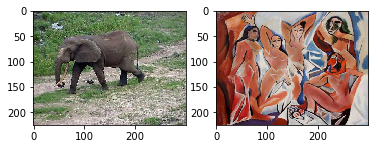

In [10]:
fig = plt.figure()

img_content = image.load_img(content_path, target_size=(h, w))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img_content)

img_style = image.load_img(style_path, target_size=(h, w))
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(img_style)

plt.show()

In [11]:
# loading and preprocessing input images
content_img = load_img_and_preprocess(content_path, (h, w))
style_img = load_img_and_preprocess(style_path, (h, w))

print(content_img.shape)
print(style_img.shape)

(1, 225, 300, 3)
(1, 225, 300, 3)


In [12]:
batch_shape = content_img.shape
shape = content_img.shape[1:]

print(batch_shape)
print(shape)

(1, 225, 300, 3)
(225, 300, 3)


In [13]:
# load the complete model
vgg = VGG16_AvgPool(shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0


In [14]:
# load the content model and we only want one output from this which is from 13th layer
content_model = Model(vgg.input, vgg.layers[13].get_output_at(0))

# target outputs from content image
content_target = K.variable(content_model.predict(content_img))

content_model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 225, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 225, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 150, 128)     147584   

In [15]:
# index 0 correspond to the original vgg with maxpool so we do get_output_at(1) which corresponds to vgg with avg pool
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# we collect all the convolutional layers in this list because we will need to take output from all of them
symbolic_conv_outputs

[<tf.Tensor 'block1_conv1_1/Relu:0' shape=(None, 225, 300, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_1/Relu:0' shape=(None, 112, 150, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_1/Relu:0' shape=(None, 56, 75, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_1/Relu:0' shape=(None, 28, 37, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_1/Relu:0' shape=(None, 14, 18, 512) dtype=float32>]

In [16]:
# make a big model that outputs multiple layers' outputs(outputs from all layers stored in list symbolic_conv_outputs)
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets from convolutional outputs at each layer in symbolic_conv_outputs
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

style_model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            multiple             0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 225, 300, 64) 1792        input_1[1][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 225, 300, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 112, 150, 64) 0          

In [17]:
# we will assume the weight of the content loss is 1 and only weight the style losses
# style_weights = [0.2, 0.4, 0.3, 0.5, 0.2]
style_weights = [5, 4, 8, 7, 9]

In [18]:
# create the total loss which is the sum of content + style loss

loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0])

In [19]:
content_model.input

<tf.Tensor 'input_1:0' shape=(None, 225, 300, 3) dtype=float32>

In [20]:
style_model.input

<tf.Tensor 'input_1:0' shape=(None, 225, 300, 3) dtype=float32>

In [21]:
content_model.output

<tf.Tensor 'block4_conv3/Relu:0' shape=(None, 28, 37, 512) dtype=float32>

In [22]:
style_model.output

[<tf.Tensor 'block1_conv1_1/Relu:0' shape=(None, 225, 300, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_1/Relu:0' shape=(None, 112, 150, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_1/Relu:0' shape=(None, 56, 75, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_1/Relu:0' shape=(None, 28, 37, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_1/Relu:0' shape=(None, 14, 18, 512) dtype=float32>]

In [23]:
# NOTE: it doesn't matter which model's input you use they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)

In [24]:
get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)

def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

In [25]:
# converting image shape to 1d array
img = np.reshape(content_img, (-1))
img.shape

(202500,)

iter=1, loss=14908.75390625
iter=2, loss=6712.1474609375
iter=3, loss=4878.84375
iter=4, loss=4097.85888671875
iter=5, loss=3610.35009765625
iter=6, loss=3316.75
iter=7, loss=3111.816650390625
iter=8, loss=2973.6328125
iter=9, loss=2869.751708984375
iter=10, loss=2791.61083984375
duration: 0:00:29.018460


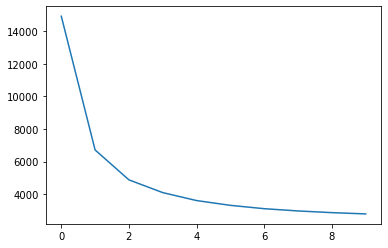

In [26]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape, img)

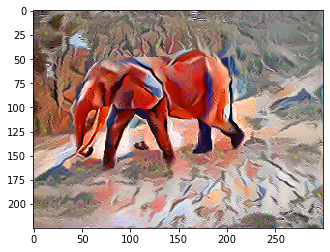

In [27]:
plt.imshow(scale_img(final_img))
plt.show()